# Create a `flotilla` study from the Illumina Bodymap 2.0 data

By: Olga Botvinnik

In this example, we will create a [`flotilla`](https://github.com/YeoLab/flotilla) study from the [Illumina](http://www.illumina.com) Bodymap 2.0 data. This is a nice dataset because it is simple yet complex. It has several nice features:

* Already processed to publically available gene expression values
* 16 human tissue types, so its relatable to people across biological disciplines, and to non-scientists (everyone knows what a brain is)
* Can group the tissue types as meta-types

These data are available from the European Bioinformatics Institute (EBI) website [here](http://www.ebi.ac.uk/gxa/experiments/E-MTAB-513?ref=aebrowse) (you can browse their other datasets on their [Data library](http://science.illumina.com/science/data_library.html) website). There's a link on the "[Expression Atlas](http://www.ebi.ac.uk/gxa/experiments/E-MTAB-513?ref=aebrowse)" view of the data to download the processed data, which is the link I use below. So let's get this data!

## Download the data and supplement

In [40]:
! curl http://www.ebi.ac.uk/gxa/experiments/E-MTAB-513.tsv > E-MTAB-513.tsv
! curl http://www.ebi.ac.uk/arrayexpress/files/E-MTAB-513/E-MTAB-513.sdrf.txt>  E-MTAB-513.sdrf.txt

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 39860  100 39860    0     0  32219      0  0:00:01  0:00:01 --:--:-- 32249


What does this look like? Let's look at the top of the file with `head`.

In [39]:
! head E-MTAB-513.tsv

# Expression Atlas version: 0.1.4-SNAPSHOT
# Query: Genes matching: 'protein_coding' exactly, specifically expressed in any Organism part above the expression level cutoff: 0.5 in experiment E-MTAB-513
# Timestamp: Sun, 11-Jan-2015 23:58:59
Gene ID	Gene Name	adipose tissue	adrenal gland	animal ovary	brain	breast	colon	heart	kidney	leukocyte	liver	lung	lymph node	prostate	skeletal muscle	testis	thyroid
ENSG00000000003	TSPAN6	21	5	21	5	16	12	2	13		31	11	5	13		18	15
ENSG00000000005	TNMD	16	5			44	1									0.6	
ENSG00000000419	DPM1	20	31	33	25	26	25	23	35	29	17	25	27	32	18	42	44
ENSG00000000457	SCYL3	1	3	4	2	3	1	1	3	4	2	1	3	3	0.9	3	3
ENSG00000000460	C1orf112	0.7	0.8	0.8		0.6			0.6	0.6	0.7		0.9	0.9		5	0.7
ENSG00000000938	FGR	9	7	1	1	2	1	2	3	147	2	26	11	2	0.7	0.8	2


In [41]:
! head E-MTAB-513.sdrf.txt

Source Name	Material Type	Description	Characteristics[organism]	Characteristics[age]	Unit[TimeUnit]	Characteristics[organism part]	Characteristics[sex]	Characteristics[ethnic group]	Comment[biosource provider]	Protocol REF	Extract Name	Material Type	Comment[LIBRARY_LAYOUT]	Comment[ORIENTATION]	Comment[NOMINAL_LENGTH]	Comment[NOMINAL_SDEV]	Comment[LIBRARY_SOURCE]	Comment[LIBRARY_STRATEGY]	Comment[LIBRARY_SELECTION]	Comment[spiked_in]	Comment[insertSize]	Comment[LIBRARYPREP]	Protocol REF	Performer	Assay Name	Technology Type	Comment[ENA_EXPERIMENT]	Comment[CYCLE_COUNT]	Comment[SPOT_LENGTH]	Comment[SEQUENCE_LENGTH]	Comment[READ_INDEX_0_READ_TYPE]	Comment[READ_INDEX_0_READ_CLASS]	Comment[READ_INDEX_0_BASE_COORD]	Comment[READ_INDEX_1_READ_TYPE]	Comment[READ_INDEX_1_READ_CLASS]	Comment[READ_INDEX_1_BASE_COORD]	Protocol REF	Scan Name	Comment[FASTQ_URI]	Comment[ENA_RUN]	Comment[SUBMITTED_FILE_NAME]	Comment[quality_scoring_system]	Comment[quality_encoding]	Comment[ascii_offset]	Factor Value[orga

We'll use the [`pandas`](http://pandas.pydata.org) data analysis library to read the data. But we'll need a few caveats. 

1. The first three lines of the data don't match the tabular format, so we'll need to ignore them with `skiprows=3`.
2. The row names indicating the gene name are the first two columns, so we'll need to specify that with `index_col=[0, 1]`, which says that the index columns/row names are the 0th and 1st columns, since we're counting from zero in the computer world.

Let's import pandas and all the other packages we'll need.

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import flotilla

:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [4]:
expression = pd.read_table('E-MTAB-513.tsv', skiprows=3, index_col=[0, 1])
expression.head()

,,adipose tissue,adrenal gland,animal ovary,brain,breast,colon,heart,kidney,leukocyte,liver,lung,lymph node,prostate,skeletal muscle,testis,thyroid
Gene ID,Gene Name,,,,,,,,,,,,,,,,
ENSG00000000003,TSPAN6,21.0,5.0,21.0,5,16.0,12,2,13.0,NaN,31.0,11,5.0,13.0,NaN,18.0,15.0
ENSG00000000005,TNMD,16.0,5.0,NaN,NaN,44.0,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.6,NaN
ENSG00000000419,DPM1,20.0,31.0,33.0,25,26.0,25,23,35.0,29.0,17.0,25,27.0,32.0,18.0,42.0,44.0
ENSG00000000457,SCYL3,1.0,3.0,4.0,2,3.0,1,1,3.0,4.0,2.0,1,3.0,3.0,0.9,3.0,3.0
ENSG00000000460,C1orf112,0.7,0.8,0.8,NaN,0.6,NaN,NaN,0.6,0.6,0.7,NaN,0.9,0.9,NaN,5.0,0.7


Interesting side note: you'll notice that "animal ovary" is the only thing indicated as "animal." This is because in the [Experimental Factor Ontology](http://bioportal.bioontology.org/ontologies/EFO) (EFO), they are defined as "[animal ovary](http://bioportal.bioontology.org/ontologies/EFO/?p=classes&conceptid=http%3A%2F%2Fwww.ebi.ac.uk%2Fefo%2FEFO_0000973&jump_to_nav=true)." This is because the EFO defines [plant ovary](http://bioportal.bioontology.org/ontologies/EFO/?p=classes&conceptid=http%3A%2F%2Fwww.ebi.ac.uk%2Fefo%2FEFO_0001052&jump_to_nav=true) separately. Apparently, in the venn diagram of the organs in animals versus the organs in plants, ovary is one of the few things that overlap! Cool! Thanks to [Nick Semenkovich](https://nick.semenkovich.com/) for [figuring this out](https://twitter.com/semenko/status/542049262725386240).

![Plant and animal organ overlap](http://i.imgur.com/JlgUDA8.png)

For `flotilla`, we follow the machine learning standard of using matrices in the format $(\text{samples}) \times (\text{features})$, like this

![Machine learning standard of a samples times feature matrix](http://i.imgur.com/Ckg4FiS.png)

Since this data is $(\text{features}) \times (\text{samples})$, we simply need to transpose the matrix with `.T`

In [5]:
expression = expression.T
expression.head()

Gene ID,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,ENSG00000001460,ENSG00000001461,ENSG00000001497,ENSG00000001561,ENSG00000001617,ENSG00000001626,ENSG00000001629,ENSG00000001630,ENSG00000001631,ENSG00000002016,
Gene Name,TSPAN6,TNMD,DPM1,SCYL3,C1orf112,FGR,CFH,FUCA2,GCLC,NFYA,STPG1,NIPAL3,LAS1L,ENPP4,SEMA3F,CFTR,ANKIB1,CYP51A1,KRIT1,RAD52,
adipose tissue,21,16,20,1,0.7,9,18,27,5,6,0.7,2,6,13,17.0,NaN,6,0.7,4,1,...
adrenal gland,5,5,31,3,0.8,7,26,24,8,5,0.9,3,8,8,6.0,NaN,7,NaN,7,4,...
animal ovary,21,NaN,33,4,0.8,1,99,30,6,11,2.0,3,7,4,2.0,0.7,11,1.0,9,3,...
brain,5,NaN,25,2,NaN,1,4,13,10,6,2.0,23,6,31,0.9,NaN,14,0.8,5,2,...
breast,16,44,26,3,0.6,2,23,27,11,6,1.0,4,4,13,3.0,NaN,9,NaN,5,2,...


Now, let's also replace all our NAs with 0s. This makes sense because if a gene is not detected, then its expression value will be 0. From the header file of the original data, it said:

    Genes matching: 'protein_coding' exactly, specifically expressed in any Organism part above the expression level cutoff: 0.5 in experiment E-MTAB-513
    
So we're forcing everything with expression less than 0.5 down to 0. Out of curiousity, let's see what was the minimum value left over after they did this 0.5 filter:

In [8]:
expression.min().min()

0.59999999999999998

Cool, pretty close to 0.5. Now let's replace all NAs with 0, with `fillna(0)`.

In [9]:
expression = expression.fillna(0)

Finally, we will add 1 and log-transform the data, so it's closer to normally distributed. Gene expression data is known to be log-normal.

In [10]:
expression = np.log2(expression + 1)

### Create metadata about the expression features

The other thing that will make this data simpler to work with is making the columns of the data just use the crazy unique ENSEMBL id like "`ENSG00000280433`". First, let's check to see if the common names are actually unique. We'll expand out the column names to a list of tuples using `expression.columns.tolist()`

In [11]:
ensembl_ids = pd.Index([a for a, b in expression.columns.tolist()])
gene_names = pd.Index([b for a, b in expression.columns.tolist()])

In [12]:
len(ensembl_ids.unique())

17412

In [13]:
len(gene_names.unique())

17396

So there's fewer unique gene names, meaning we should use the ENSEMBL ids for the unique IDs. We'll do this by resetting the columns of `expression`, and creating metadata about the expression features, stored as `expression_feature_data`.

First, let's reassign the columns as the `ensembl_ids` we created from before.

In [14]:
expression.columns = ensembl_ids

Now let's create the `expression_feature_data` DataFrame, and add a column of `'gene_name'` for the renamed feature.

In [15]:
expression_feature_data = pd.DataFrame(index=ensembl_ids)
expression_feature_data['gene_name'] = gene_names
expression_feature_data.head()

,gene_name
ENSG00000000003,TSPAN6
ENSG00000000005,TNMD
ENSG00000000419,DPM1
ENSG00000000457,SCYL3
ENSG00000000460,C1orf112


## Preparing the metadata

For `flotilla`, every project is required to have metadata. We'll create one from scratch using the sample names from the expression data.

In [16]:
metadata = pd.DataFrame(index=expression.index)
metadata.head()

"Index([u'adipose tissue', u'adrenal gland', u'animal ovary', u'brain', u'breast'], dtype='object')",Empty DataFrame


The first category we'll use is pretty straightforward, it'll just be the name of the tissue. We can just use the index as the `'phenotype'`.

In [18]:
metadata['phenotype'] = metadata.index
metadata.head()

,phenotype
adipose tissue,adipose tissue
adrenal gland,adrenal gland
animal ovary,animal ovary
brain,brain
breast,breast


Next, let's add some categories on the data, grouping different tissue types together that have the same structure or function. My awesome MD/PhD friend [Cynthia Hsu](http://mstp.ucsd.edu/people/Pages/grad-school.aspx) (you have to search for her name on the webpage) came up with these categories.

In [19]:
# All of these tissue types are part of the reproductive system
metadata['reproductive'] = metadata.phenotype.isin(['animal ovary', 'testis'])

# ALl of these tissue types generate hormones
metadata['hormonal'] = metadata.phenotype.isin(['animal ovary', 'testis', 'adrenal gland', 'thyroid'])

# These tissues are part of in the immune system
metadata['immune'] = metadata.phenotype.isin(['leukocyte', 'thyroid', 'lymph node'])

# These tissues are fatty
metadata['fatty'] = metadata.phenotype.isin(['adipose tissue', 'brain', 'breast'])

# These tissues contain either smooth (involuntary) or skeletal (voluntary) muscle
metadata['muscle'] = metadata.phenotype.isin(['colon', 'heart', 'prostate', 'skeletal muscle'])

# These tissues' main function is to filter blood in some way
metadata['filtration'] = metadata.phenotype.isin(['colon', 'kidney', 'liver'])

# These tissues have high blood flow to them, compared to other tissues
metadata['high_blood_flow'] = metadata.phenotype.isin(['brain', 'colon', 'kidney', 'liver', 'lung'])

### Assign colors to the phenotypes

Now we need to choose colors for the data. Since we have 16 samples, none of the usual [ColorBrewer](http://bl.ocks.org/mbostock/5577023) colors apply because the maximum color set there is `Paired`, which is 12 colors. So we'll use a human-friendly version of the hue-lightness-saturation (hls) scale, called "husl". Read more at the [`seaborn` color tutorial](http://web.stanford.edu/~mwaskom/software/seaborn/tutorial/color_palettes.html).

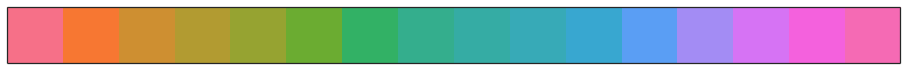

In [20]:
colors = sns.color_palette('husl', len(expression.index))
sns.palplot(colors)

Let's create an iterator so we can easily loop over this list of colors without having to reference indices.

In [21]:
colors_iter = iter(colors)

Finally, let's make the phenotype to color mapping as a dictionary.

In [22]:
phenotype_to_color = {phenotype: colors_iter.next() for phenotype in metadata.phenotype}
phenotype_to_color

{'adipose tissue': (0.9677975592919913,
  0.44127456009157356,
  0.5358103155058701),
 'adrenal gland': (0.9688417625390765,
  0.46710871459052145,
  0.1965441952393453),
 'animal ovary': (0.8087954113106306, 0.5634700050056693, 0.19502642696727285),
 'brain': (0.7008633391290917, 0.6080365980075504, 0.19419512204856468),
 'breast': (0.5920891529639701, 0.6418467016378244, 0.1935069134991043),
 'colon': (0.4225883781014591, 0.677943504931845, 0.19271544738133076),
 'heart': (0.19783576093349015, 0.6955516966063037, 0.3995301037444499),
 'kidney': (0.20518528131112984, 0.6851497738530601, 0.5562527763557912),
 'leukocyte': (0.21044753832183283, 0.6773105080456748, 0.6433941168468681),
 'liver': (0.21576108198845112, 0.6690446872415565, 0.7201192992055431),
 'lung': (0.22335772267769388, 0.6565792317435265, 0.8171355503265633),
 'lymph node': (0.3531380715309417, 0.6201408220829481, 0.9586195235634788),
 'prostate': (0.6423044349219739, 0.5497680051256467, 0.9582651433656727),
 'skeletal

## Make a `flotilla` study!

In [26]:
study = flotilla.Study(metadata, expression_data=expression, 
                       metadata_phenotype_to_color=phenotype_to_color, 
                       expression_feature_data=expression_feature_data, 
                       expression_feature_rename_col='gene_name',
                       species='hg19')
study.expression.feature_data.head()

2015-01-11 13:50:44	Initializing Study
2015-01-11 13:50:44	Initializing Predictor configuration manager for Study
2015-01-11 13:50:44	Predictor ExtraTreesClassifier is of type <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>
2015-01-11 13:50:44	Added ExtraTreesClassifier to default predictors
2015-01-11 13:50:44	Predictor ExtraTreesRegressor is of type <class 'sklearn.ensemble.forest.ExtraTreesRegressor'>
2015-01-11 13:50:44	Added ExtraTreesRegressor to default predictors
2015-01-11 13:50:44	Predictor GradientBoostingClassifier is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingClassifier'>
2015-01-11 13:50:44	Added GradientBoostingClassifier to default predictors
2015-01-11 13:50:44	Predictor GradientBoostingRegressor is of type <class 'sklearn.ensemble.gradient_boosting.GradientBoostingRegressor'>
2015-01-11 13:50:44	Added GradientBoostingRegressor to default predictors
2015-01-11 13:50:44	Loading metadata
2015-01-11 13:50:44	Loading species metadata from ~/f

No phenotype to marker (matplotlib plotting symbol) was provided, so each phenotype will be plotted as a circle in visualizations.
Error loading species hg19 data 

2015-01-11 13:50:49	Loading expression data
2015-01-11 13:50:49	Initializing expression
2015-01-11 13:50:49	Done initializing expression
2015-01-11 13:50:50	Successfully initialized a Study object!


,biomark_neural_panel,confident_rbp,gencode_id,gene_name,gene_status,gene_type,havana_gene,level,rbp,ribosomal,ribosomal_subunit,synapse,tag,transcript_id,transcript_name,transcript_status,transcript_type,transcription_factor
ENSG00000000003,False,False,ENSG00000000003.10,TSPAN6,KNOWN,protein_coding,OTTHUMG00000022002.1,2,False,False,False,False,None,ENSG00000000003.10,TSPAN6,KNOWN,protein_coding,False
ENSG00000000005,False,False,ENSG00000000005.5,TNMD,KNOWN,protein_coding,OTTHUMG00000022001.1,2,False,False,False,False,None,ENSG00000000005.5,TNMD,KNOWN,protein_coding,False
ENSG00000000419,False,False,ENSG00000000419.8,DPM1,KNOWN,protein_coding,OTTHUMG00000032742.2,2,False,False,False,False,None,ENSG00000000419.8,DPM1,KNOWN,protein_coding,False
ENSG00000000457,False,False,ENSG00000000457.9,SCYL3,KNOWN,protein_coding,OTTHUMG00000035941.4,2,False,False,False,False,None,ENSG00000000457.9,SCYL3,KNOWN,protein_coding,False
ENSG00000000460,False,False,ENSG00000000460.12,C1orf112,KNOWN,protein_coding,OTTHUMG00000035821.6,2,False,False,False,False,None,ENSG00000000460.12,C1orf112,KNOWN,protein_coding,False


featurewise : False
y_pc : 2
data_type : expression
std_multiplier : 2.0
most_variant_features : False
show_point_labels : False
plot_violins : False
sample_subset : all_samples
feature_subset : variant
bokeh : False
color_samples_by : phenotype
x_pc : 1
list_link : 


<function flotilla.visualize.ipython_interact.do_interact>

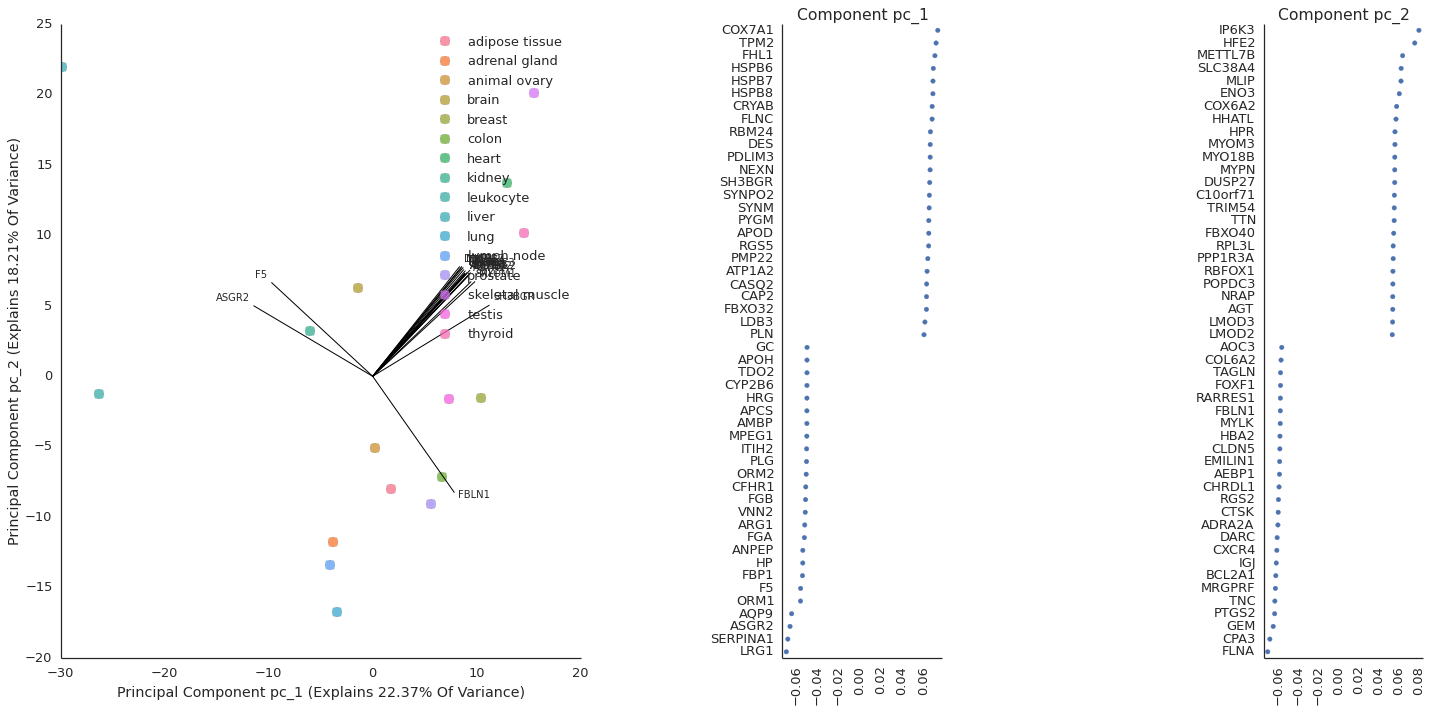

In [27]:
study.interactive_pca()

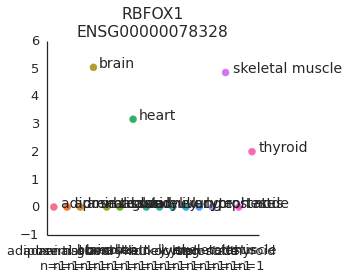

In [33]:
study.plot_gene('RBFOX1')

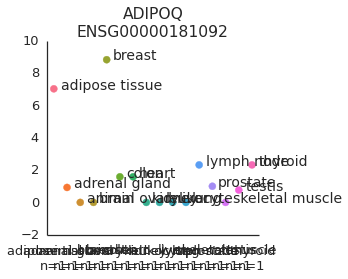

In [34]:
study.plot_gene('ADIPOQ')

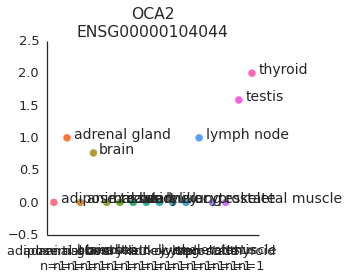

In [35]:
study.plot_gene('OCA2')

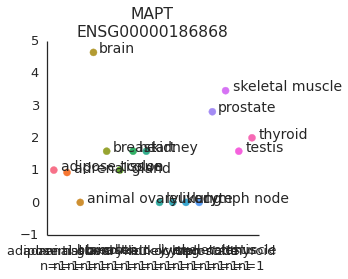

In [37]:
study.plot_gene('MAPT')

In [42]:
era_metadata = pd.read_table("E-MTAB-513.sdrf.txt")

In [44]:
from pprint import pprint

In [45]:
pprint(sorted(era_metadata.columns.tolist()))

['Assay Name',
 'Characteristics[age]',
 'Characteristics[ethnic group]',
 'Characteristics[organism part]',
 'Characteristics[organism]',
 'Characteristics[sex]',
 'Comment[CYCLE_COUNT]',
 'Comment[ENA_EXPERIMENT]',
 'Comment[ENA_RUN]',
 'Comment[FASTQ_URI]',
 'Comment[LIBRARYPREP]',
 'Comment[LIBRARY_LAYOUT]',
 'Comment[LIBRARY_SELECTION]',
 'Comment[LIBRARY_SOURCE]',
 'Comment[LIBRARY_STRATEGY]',
 'Comment[NOMINAL_LENGTH]',
 'Comment[NOMINAL_SDEV]',
 'Comment[ORIENTATION]',
 'Comment[READ_INDEX_0_BASE_COORD]',
 'Comment[READ_INDEX_0_READ_CLASS]',
 'Comment[READ_INDEX_0_READ_TYPE]',
 'Comment[READ_INDEX_1_BASE_COORD]',
 'Comment[READ_INDEX_1_READ_CLASS]',
 'Comment[READ_INDEX_1_READ_TYPE]',
 'Comment[SEQUENCE_LENGTH]',
 'Comment[SPOT_LENGTH]',
 'Comment[SUBMITTED_FILE_NAME]',
 'Comment[ascii_offset]',
 'Comment[biosource provider]',
 'Comment[insertSize]',
 'Comment[quality_encoding]',
 'Comment[quality_scoring_system]',
 'Comment[spiked_in]',
 'Description',
 'Extract Name',
 'Facto

In [46]:
era_metadata['Comment[biosource provider]']

0                Human kidney total RNA, lot 0908002
1                Human kidney total RNA, lot 0908002
2                Human kidney total RNA, lot 0908002
3                Human heart total RNA, lot 07040023
4                Human heart total RNA, lot 07040023
5                Human heart total RNA, lot 07040023
6               Human liver total RNA, lot 040000124
7               Human liver total RNA, lot 040000124
8               Human liver total RNA, lot 040000124
9                  Human lung total RNA, lot 0904002
10                 Human lung total RNA, lot 0904002
11                 Human lung total RNA, lot 0904002
12    Human lymph node total RNA, lot 026P010305032B
13    Human lymph node total RNA, lot 026P010305032B
14    Human lymph node total RNA, lot 026P010305032B
...
49      
50      
51      
52      
53      
54      
55      
56      
57      
58      
59      
60      
61      
62      
63      
Name: Comment[biosource provider], Length: 64, dtype: object

In [47]:
era_metadata['Scan Name']

0          75bp_mRNA_Seq_FCA_s_6_sequence.txt.gz
1     50bp_PE_mRNA_Seq_FCB_s_6_1_sequence.txt.gz
2     50bp_PE_mRNA_Seq_FCB_s_6_2_sequence.txt.gz
3          75bp_mRNA_Seq_FCA_s_7_sequence.txt.gz
4     50bp_PE_mRNA_Seq_FCB_s_7_1_sequence.txt.gz
5     50bp_PE_mRNA_Seq_FCB_s_7_2_sequence.txt.gz
6          75bp_mRNA_Seq_FCA_s_8_sequence.txt.gz
7     50bp_PE_mRNA_Seq_FCB_s_8_1_sequence.txt.gz
8     50bp_PE_mRNA_Seq_FCB_s_8_2_sequence.txt.gz
9     50bp_PE_mRNA_Seq_FCA_s_8_1_sequence.txt.gz
10    50bp_PE_mRNA_Seq_FCA_s_8_2_sequence.txt.gz
11         75bp_mRNA_Seq_FCB_s_1_sequence.txt.gz
12    50bp_PE_mRNA_Seq_FCA_s_7_1_sequence.txt.gz
13    50bp_PE_mRNA_Seq_FCA_s_7_2_sequence.txt.gz
14         75bp_mRNA_Seq_FCB_s_2_sequence.txt.gz
...
49    100bp_Stranded_RNA_Seq_FCA_s_2_sequence.txt.gz
50    100bp_Stranded_RNA_Seq_FCA_s_3_sequence.txt.gz
51    100bp_Stranded_RNA_Seq_FCB_s_1_sequence.txt.gz
52    100bp_Stranded_RNA_Seq_FCB_s_2_sequence.txt.gz
53    100bp_Stranded_RNA_Seq_FCA_s_4_sequence.txt

In [48]:
era_metadata['Material Type']

0     organism part
1     organism part
2     organism part
3     organism part
4     organism part
5     organism part
6     organism part
7     organism part
8     organism part
9     organism part
10    organism part
11    organism part
12    organism part
13    organism part
14    organism part
...
49    organism part
50    organism part
51    organism part
52    organism part
53    organism part
54    organism part
55    organism part
56    organism part
57    organism part
58    organism part
59    organism part
60    organism part
61    organism part
62    organism part
63    organism part
Name: Material Type, Length: 64, dtype: object

In [49]:
era_metadata['Material Type.1']

0     total_RNA
1     total_RNA
2     total_RNA
3     total_RNA
4     total_RNA
5     total_RNA
6     total_RNA
7     total_RNA
8     total_RNA
9     total_RNA
10    total_RNA
11    total_RNA
12    total_RNA
13    total_RNA
14    total_RNA
...
49    molecular_mixture
50    molecular_mixture
51    molecular_mixture
52    molecular_mixture
53    molecular_mixture
54    molecular_mixture
55    molecular_mixture
56    molecular_mixture
57    molecular_mixture
58    molecular_mixture
59    molecular_mixture
60    molecular_mixture
61    molecular_mixture
62    molecular_mixture
63    molecular_mixture
Name: Material Type.1, Length: 64, dtype: object

In [50]:
era_metadata.Description

0       1x75 single mRNA-Seq
1     2x50 PE mRNA-seq READ1
2     2x50 PE mRNA-seq READ2
3       1x75 single mRNA-Seq
4     2x50 PE mRNA-seq READ1
5     2x50 PE mRNA-seq READ2
6       1x75 single mRNA-Seq
7     2x50 PE mRNA-seq READ1
8     2x50 PE mRNA-seq READ2
9     2x50 PE mRNA-seq READ1
10    2x50 PE mRNA-seq READ2
11      1x75 single mRNA-Seq
12    2x50 PE mRNA-seq READ1
13    2x50 PE mRNA-seq READ2
14      1x75 single mRNA-Seq
...
49    1x100 stranded total transcriptome preps; the ...
50    1x100 stranded total transcriptome preps; the ...
51    1x100 stranded total transcriptome preps; the ...
52    1x100 stranded total transcriptome preps; the ...
53    1x100 stranded total transcriptome preps; the ...
54    1x100 stranded total transcriptome preps; the ...
55    1x100 stranded total transcriptome preps; the ...
56    1x100 stranded total transcriptome preps; the ...
57    1x100 stranded total transcriptome preps; the ...
58    1x100 stranded total transcriptome preps; the ...
5

data_type : expression
metric : euclidean
sample_subset : all_samples
feature_subset : biomark_neural_panel
fig_height : 
scale_fig_by_data : True
fig_width : 
list_link : 
method : average


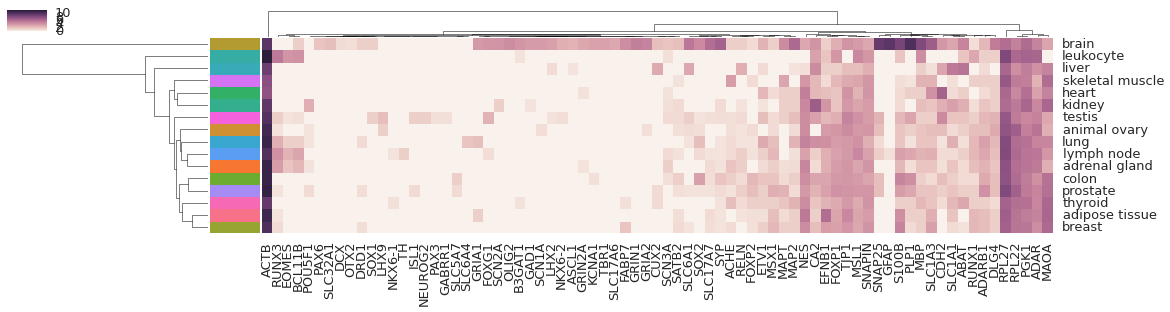

In [55]:
study.interactive_clustermap()

In [ ]:
study.save('bodymap2')